In [1]:
from platform import python_version

print(python_version())

3.7.4


In [2]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
# sys.path.append('./secrets.py')
import mysecrets
import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=mysecrets.HOST,
    port=mysecrets.PORT,
    username=mysecrets.USERNAME,
    password=mysecrets.PASSWORD,
    database=mysecrets.DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


In [3]:
data.shape

(9542085, 41)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9542085 entries, 2019-10-01 00:00:04+00:00 to 2020-04-29 23:59:56+00:00
Data columns (total 41 columns):
cellular                   object
co2                        float64
current                    float64
event                      object
fw_version                 object
humidity                   float64
name                       object
notes                      object
pm1                        float64
pm10                       float64
pm2_5                      float64
pm4                        float64
power                      float64
published                  object
queue_size                 float64
reset_reason               float64
reset_reason_data          float64
rtc_temperature            float64
sensor_id                  object
sequence                   int64
serial_number              object
system_firmware_version    object
temperature                float64
total_energy               float64
voltage      

In [5]:
# head() gets the first 5 rows
data.head()

# Or you can specify how many lines you want:
# data.head(50)

,cellular,co2,current,event,fw_version,humidity,name,notes,pm1,pm10,...,outdoor,stay_at_home,free_memory,geohash,heat_source,last_heard,stay_home,functions,online,variables
2019-10-01 00:00:04+00:00,True,1202.0,NaN,mn/d,2,59.7,CT,None,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01 00:00:05+00:00,True,1663.0,NaN,mn/d,2,72.0,MA,None,68.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01 00:00:06+00:00,True,3496.0,NaN,mn/d,2,74.2,DE,None,7.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01 00:00:06+00:00,True,621.0,NaN,mn/d,2,120.9,OR,None,11.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01 00:00:10+00:00,True,909.0,NaN,mn/d,2,42.0,ME,None,69.0,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# tail() gets the last 5 rows
data.tail()

,cellular,co2,current,event,fw_version,humidity,name,notes,pm1,pm10,...,outdoor,stay_at_home,free_memory,geohash,heat_source,last_heard,stay_home,functions,online,variables
2020-04-29 23:59:41+00:00,True,5119.0,NaN,mn/d,3,48.2,KS,None,11.0,12.0,...,False,NaN,NaN,y2ebwggjw4b0,Stove and heater,2020-04-30T00:00:44.891Z,False,NaN,NaN,NaN
2020-04-29 23:59:41+00:00,True,431.0,0.037,mn/d,3,23.4,Kane,At Joseph’s house.,0.0,0.0,...,False,NaN,NaN,None,None,2020-04-29T23:53:43.576Z,None,NaN,NaN,NaN
2020-04-29 23:59:44+00:00,True,767.0,NaN,mn/d,3,41.0,ME,None,14.0,15.0,...,False,NaN,NaN,y2ebwgcvffwg,Stove and heater,2020-04-30T00:04:43.278Z,True,NaN,NaN,NaN
2020-04-29 23:59:54+00:00,True,546.0,NaN,mn/d,3,31.1,Davis,"At Phil's home, inside.",1.0,1.0,...,False,NaN,NaN,None,None,2020-04-29T23:49:55.135Z,None,NaN,NaN,NaN
2020-04-29 23:59:56+00:00,True,NaN,NaN,mn/d,3,10.8,Daryl,None,0.0,0.0,...,True,NaN,NaN,None,None,2020-04-29T23:55:02.534Z,None,NaN,NaN,NaN


In [7]:
# Describe gives a statistical overview of our data
data.describe()

,co2,current,humidity,pm1,pm10,pm2_5,pm4,power,queue_size,reset_reason,reset_reason_data,rtc_temperature,sequence,temperature,total_energy,voltage,free_memory
count,8.581722e+06,1.133718e+06,8.716839e+06,8.662786e+06,8.662786e+06,8.662786e+06,8.662786e+06,1.088866e+06,9.542061e+06,6.798000e+03,200.000000,9.107530e+06,9.542085e+06,8.716839e+06,1.088820e+06,1.088820e+06,7620.000000
mean,1.369474e+03,2.123375e+00,-9.465983e+02,8.293342e+01,-1.631471e+03,-3.999162e+02,-1.137009e+03,4.711593e+02,4.386227e+02,-2.369190e+06,1.090000,2.699213e+01,1.313669e+05,-9.844201e+02,4.384125e+01,1.621077e+02,54555.107612
std,1.093098e+03,2.776020e+00,4.707841e+05,2.621830e+02,2.188882e+06,1.459255e+06,1.631496e+06,5.964901e+02,4.632831e+03,1.275321e+08,0.897736,1.055027e+01,2.429187e+06,4.766815e+05,1.334564e+02,6.927579e+01,4316.242249
min,0.000000e+00,0.000000e+00,-2.147484e+08,0.000000e+00,-2.147484e+09,-2.147484e+09,-2.147484e+09,0.000000e+00,0.000000e+00,-2.113500e+09,1.000000,-4.350000e+01,-2.004318e+09,-2.147484e+08,0.000000e+00,0.000000e+00,25568.000000
25%,6.290000e+02,0.000000e+00,2.610000e+01,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,4.000000e+01,1.000000,2.400000e+01,7.147900e+04,1.460000e+01,6.800000e-01,1.200000e+02,55528.000000
50%,1.067000e+03,3.900000e-02,3.700000e+01,2.200000e+01,2.500000e+01,2.400000e+01,2.500000e+01,2.000000e+00,5.000000e+00,4.000000e+01,1.000000,2.875000e+01,1.247210e+05,1.950000e+01,4.586000e+00,1.230000e+02,55544.000000
75%,1.668000e+03,5.274000e+00,4.860000e+01,8.600000e+01,9.500000e+01,9.300000e+01,9.500000e+01,1.157000e+03,7.000000e+00,1.400000e+02,1.000000,3.300000e+01,1.891610e+05,2.410000e+01,2.849900e+01,2.270000e+02,55552.000000
max,2.836400e+04,2.116600e+01,2.029419e+08,2.215100e+04,2.147484e+09,2.147484e+09,1.353850e+05,2.522000e+03,8.375700e+04,2.114614e+09,10.000000,8.050000e+01,3.397690e+05,2.147484e+08,5.711786e+03,2.490000e+02,65600.000000


In [8]:
data.columns

Index(['cellular', 'co2', 'current', 'event', 'fw_version', 'humidity', 'name',
       'notes', 'pm1', 'pm10', 'pm2_5', 'pm4', 'power', 'published',
       'queue_size', 'reset_reason', 'reset_reason_data', 'rtc_temperature',
       'sensor_id', 'sequence', 'serial_number', 'system_firmware_version',
       'temperature', 'total_energy', 'voltage', 'card_present', 'deployed',
       'location', 'location_name', 'modified_ger', 'number_of_people',
       'outdoor', 'stay_at_home', 'free_memory', 'geohash', 'heat_source',
       'last_heard', 'stay_home', 'functions', 'online', 'variables'],
      dtype='object')

2019-10-05 09:46:16+08:00
2019-10-05 09:46:16+08:00


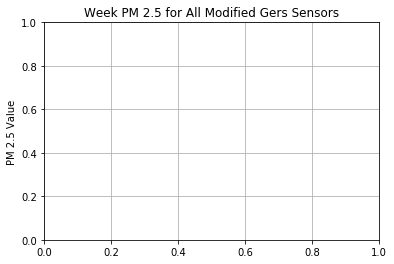

In [15]:
# all_modified_gers - This is the working boxplot for all_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

# Don't include sensors: FL, IA, KS, MB, NB, NJ, NL, OR, WA, WY
# Look more closely at: NE, NS

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
print(data.index[1])
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Modified Gers', 'All Unmodified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data = data[data.humidity < 80] # Removing 80% humidity from data
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100))))) # formula to correct humidity from low cost sensors

# START -  new way to apply a formula to a column (need to verify if we want to use this method as compared to one liner from above)
# def remove_humidity(col):
#     col /= (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
#     return col

# data['pm2_5'].apply(remove_humidity)
# End

# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']

# data['pm2_5'].dropna(inplace=True)
# data.reset_index(drop=True)

# start clean up data mode when in office or switched from outdoor to indoor or vice versa

# -------------------------- In Office ----------------------------------------------------------------------------------------------------------------------------
ak = data[data.index < '2020-02-15'].groupby("name").get_group('AK')
co = data[data.index < '2020-02-15'].groupby("name").get_group('CO')
ky = data[data.index < '2020-02-15'].groupby("name").get_group('KY')

# mb = data[data.index < '2020-02-15'].groupby("name").get_group('MB')
# mb = mb[(mb.index < '2020-01-26') | (mb.index >= '2020-02-04')]

# nj = data[(data.index < '2020-01-28') | (data.index >= '2020-02-04')].groupby("name").get_group('NJ')
nu = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('NU')
# oregon = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('OR')
pe = data[(data.index < '2020-02-11')].groupby("name").get_group('PE') #outdoor sensor we are no longer using these sensors data
# wy = data[(data.index < '2020-02-11')].groupby("name").get_group('WY') 

# --------------------------------------- Switched ---------------------------------------------------------------------------------------------------------------

ab = data[(data.index > '2020-01-28') & (data.index <= '2020-02-14')].groupby("name").get_group('AB') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ns = data[(data.index >= '2020-01-28')].groupby("name").get_group('NS') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
# oregon = oregon[(oregon.index >= '2020-01-28')] # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ut = data[(data.index >= '2020-01-29')].groupby("name").get_group('UT') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor

# finish clean up data mode when in office or switched from outdoor to indoor or vice versa
# ------------------------------------------------------------------------------------------------------------------------------------------------------

modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'ID', 'IL', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM', 'GA', 'ND', 'NE']
modified_gers_data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21])]
modified_gers_data = modified_gers_data.append(ak)
modified_gers_data = modified_gers_data.append(co)
modified_gers_data = modified_gers_data.append(ky)
# unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
# unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

unmodified_gers = ['OK', 'PA', 'RI', 'SD', 'VA', 'WI']
unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5])]
unmodified_gers_data = unmodified_gers_data.append(ab)
# unmodified_gers_data = unmodified_gers_data.append(mb)
# unmodified_gers_data = unmodified_gers_data.append(nj)
unmodified_gers_data = unmodified_gers_data.append(nu)
unmodified_gers_data = unmodified_gers_data.append(ns)
# unmodified_gers_data = unmodified_gers_data.append(oregon)
unmodified_gers_data = unmodified_gers_data.append(ut)


In [ ]:
# remove high humidity data points based on humidity 

# all_modified_gers = modified_gers_data.pm2_5.dropna()
# print('{} data points before removing humidity above threshold size: {}\n'.format(labels[0], len(all_modified_gers)))

# eighty_humidity = modified_gers_data[modified_gers_data.humidity < 80 ]
# eighty_humidity = eighty_humidity.pm2_5.dropna()
# print('{} less eighty humidity data size: {}'.format(labels[0], len(eighty_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[0], len(all_modified_gers) - len(eighty_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[0], 100 - (len(eighty_humidity)/len(all_modified_gers)) * 100))

# eighty_five_humidity = modified_gers_data[modified_gers_data.humidity < 85 ]
# eighty_five_humidity = eighty_five_humidity.pm2_5.dropna()
# print('{} less eighty five humidity data size: {}'.format(labels[0], len(eighty_five_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[0], len(all_modified_gers) - len(eighty_five_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[0], 100 - (len(eighty_five_humidity)/len(all_modified_gers)) * 100))

# ninety_humidity = modified_gers_data[modified_gers_data.humidity < 90 ]
# ninety_humidity = ninety_humidity.pm2_5.dropna()
# print('{} less ninety humidity data size: {}'.format(labels[0], len(ninety_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[0], len(all_modified_gers) - len(ninety_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[0], 100 - (len(ninety_humidity)/len(all_modified_gers)) * 100))

# ninety_five_humidity = modified_gers_data[modified_gers_data.humidity < 95 ]
# ninety_five_humidity = ninety_five_humidity.pm2_5.dropna()
# print('{} less ninety five humidity data size: {}'.format(labels[0], len(ninety_five_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[0], len(all_modified_gers) - len(ninety_five_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[0], 100 - (len(ninety_five_humidity)/len(all_modified_gers)) * 100))

# output if I didn't clean for 80% and more humidity clean up
# All Modified Gers data points before removing humidity above threshold size: 4045445

# All Modified Gers less eighty humidity data size: 3999252
# All Modified Gers difference between the two sizes: 46193
# All Modified Gers percentage loss: 1.14%

# All Modified Gers less eighty five humidity data size: 4021802
# All Modified Gers difference between the two sizes: 23643
# All Modified Gers percentage loss: 0.58%

# All Modified Gers less ninety humidity data size: 4031322
# All Modified Gers difference between the two sizes: 14123
# All Modified Gers percentage loss: 0.35%

# All Modified Gers less ninety five humidity data size: 4035588
# All Modified Gers difference between the two sizes: 9857
# All Modified Gers percentage loss: 0.24%

In [ ]:
# # remove high humidity data points based on humidity 

# all_unmodified_gers = unmodified_gers_data.pm2_5.dropna()
# print('{} data points before removing humidity above threshold size: {}'.format(labels[1], len(all_unmodified_gers)))

# eighty_humidity = unmodified_gers_data[unmodified_gers_data.humidity < 80 ]
# eighty_humidity = eighty_humidity.pm2_5.dropna()
# print('{} less eighty humidity data size: {}'.format(labels[1], len(eighty_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[1], len(all_unmodified_gers) - len(eighty_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[1], 100 - (len(eighty_humidity)/len(all_unmodified_gers)) * 100))

# eighty_five_humidity = unmodified_gers_data[unmodified_gers_data.humidity < 85 ]
# eighty_five_humidity = eighty_five_humidity.pm2_5.dropna()
# print('{} less eighty five humidity data size: {}'.format(labels[1], len(eighty_five_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[1], len(all_unmodified_gers) - len(eighty_five_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[1], 100 - (len(eighty_five_humidity)/len(all_unmodified_gers)) * 100))

# ninety_humidity = unmodified_gers_data[unmodified_gers_data.humidity < 90 ]
# ninety_humidity = ninety_humidity.pm2_5.dropna()
# print('{} less ninety humidity data size: {}'.format(labels[1], len(ninety_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[1], len(all_unmodified_gers) - len(ninety_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[1], 100 - (len(ninety_humidity)/len(all_unmodified_gers)) * 100))

# ninety_five_humidity = unmodified_gers_data[unmodified_gers_data.humidity < 95 ]
# ninety_five_humidity = ninety_five_humidity.pm2_5.dropna()
# print('{} less ninety five humidity data size: {}'.format(labels[1], len(ninety_five_humidity)))
# print('{} difference between the two sizes: {}'.format(labels[1], len(all_unmodified_gers) - len(ninety_five_humidity)))
# print('{} percentage loss: {:.2f}%\n'.format(labels[1], 100 - (len(ninety_five_humidity)/len(all_unmodified_gers)) * 100))

# # output if I didn't clean for 80% and more humidity clean up
# All Unmodified Gers data points before removing humidity above threshold size: 1366338
# All Unmodified Gers less eighty humidity data size: 1238953
# All Unmodified Gers difference between the two sizes: 127385
# All Unmodified Gers percentage loss: 9.32%

# All Unmodified Gers less eighty five humidity data size: 1270944
# All Unmodified Gers difference between the two sizes: 95394
# All Unmodified Gers percentage loss: 6.98%

# All Unmodified Gers less ninety humidity data size: 1297231
# All Unmodified Gers difference between the two sizes: 69107
# All Unmodified Gers percentage loss: 5.06%

# All Unmodified Gers less ninety five humidity data size: 1317050
# All Unmodified Gers difference between the two sizes: 49288
# All Unmodified Gers percentage loss: 3.61%

In [ ]:
# remove 80% humidity and above of the data set
# all_unmodified_gers = modified_gers_data[modified_gers_data.humidity < 80 ]

All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday',
       ...
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object', length=1000)
All Modified Gers list size: 3999252


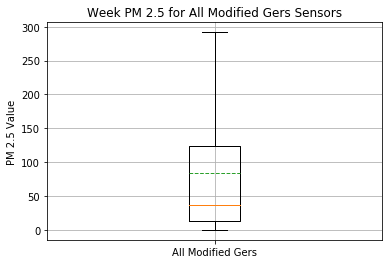

whiskers:  [0.0, 291.8367222871719]
caps:  [0.0, 291.8367222871719]
boxes:  [12.518465299181633]
medians:  [36.77299181634605]
means:  [84.41727616414266]
fliers:  []

CSV String:
 None


In [23]:
labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:1000])

# fig, ax = plt.subplots(1, 2, sharey='row', sharex='col', figsize=(15,7))
# results = ax[0].boxplot(all_modified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)
# results = ax[1].boxplot(all_modified_gers, showfliers=True, labels=labels, showmeans=True, meanline=True)

# ax[0].set_title('Week PM 2.5 for All Modified Gers Sensors With no outliers')
# ax[1].set_title('Week PM 2.5 for All Modified Gers Sensors With outliers')

all_modified_gers = modified_gers_data.pm2_5.dropna()
print('{} list size: {}'.format(labels[0], len(all_modified_gers)))
results = plt.boxplot(all_modified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.show()

# results = plt.boxplot(all_modified_gers, showfliers=True, labels=labels, showmeans=True, meanline=True)
# plt.grid(True)
# plt.show()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

# saving the DataFrame as a CSV file (https://www.geeksforgeeks.org/how-to-export-pandas-dataframe-to-a-csv-file/)
all_modified_gers_csv_data = all_modified_gers.to_csv('all_modified_gers.csv', index = True, header = True) 
print('\nCSV String:\n', all_modified_gers_csv_data)

In [17]:
# modified_gers_data.head()

In [18]:
# q1 = modified_gers_data.pm2_5.quantile(.25)
# q3 = modified_gers_data.pm2_5.quantile(.75)
# iqr = q3 - q1 
# pmin = q1 - 1.5 * iqr
# pmax = q3 + 1.5 * iqr
# new_modified_gers_data = modified_gers_data.pm2_5.where(modified_gers_data.pm2_5.between(pmin, pmax))

In [19]:
# compare = pd.DataFrame({'before':modified_gers_data.pm2_5, 'after':new_modified_gers_data})
# compare.plot.box()
# compare.describe()

All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Mon list size: 541559

CSV String:
 None
Tue list size: 557802

CSV String:
 None
Wed list size: 576422

CSV String:
 None
Thu list size: 574393

CSV String:
 None
Fri list size: 594738

CSV String:
 None
Sat list size: 584543

CSV String:
 None
Sun list size: 569795

CSV String:
 None
total for all days: 3999252

whiskers:  [0.0, 266.0173876076097, 0.0, 285.57748963758104, 0.0, 298.09595493676267, 0.0, 300.44316718035924, 0.0, 307.4848039111489, 0.0, 284.01268147518334, 0.0, 298.09595493676267]
caps:  [0.0, 266.0173876076097, 0.0, 285.57748963758104, 0.0, 298.09595493676267, 0.0, 300.44316718035924, 0.0, 307.4848039111489, 

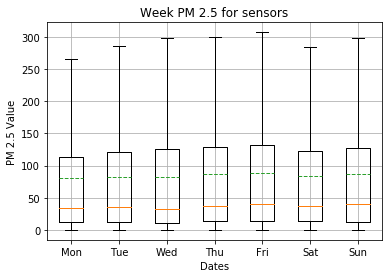

In [30]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = modified_gers_data[(modified_gers_data.index.day_name() == 'Monday')]['pm2_5'].dropna()
tuesday = modified_gers_data[modified_gers_data.index.day_name() == 'Tuesday']['pm2_5'].dropna()
wednesday = modified_gers_data[modified_gers_data.index.day_name() == 'Wednesday']['pm2_5'].dropna()
thursday = modified_gers_data[modified_gers_data.index.day_name() == 'Thursday']['pm2_5'].dropna()
friday = modified_gers_data[modified_gers_data.index.day_name() == 'Friday']['pm2_5'].dropna()
saturday = modified_gers_data[modified_gers_data.index.day_name() == 'Saturday']['pm2_5'].dropna()
sunday = modified_gers_data[modified_gers_data.index.day_name() == 'Sunday']['pm2_5'].dropna()
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    
    # saving the DataFrame as a CSV file (https://www.geeksforgeeks.org/how-to-export-pandas-dataframe-to-a-csv-file/)
    file_name = labels[i] + '_' + 'all_modified_gers.csv'
    day_all_modified_gers_csv_data = day.to_csv(file_name, index = True, header = True) 
    print('\nCSV String:\n', day_all_modified_gers_csv_data)
    
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])


All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'ID', 'IL', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Monday - AK list size: 12413
Monday - AK list size of data above 1000: 0
Monday - AL list size: 32067
Monday - AL list size of data above 1000: 0
Monday - AR list size: 19829
Monday - AR list size of data above 1000: 0
Monday - AZ list size: 32265
Monday - AZ list size of data above 1000: 0
Monday - CA list size: 23413
Monday - CA list size of data above 1000: 0
Monday - CO list size: 10078
Monday - CO list size of data above 1000: 0
Monday - CT list size: 9798
Monday - CT list size of data above 1000: 0
Monday - DE list size: 35756
Monday - DE list size of data above 1000: 0
Monday - GA list size: 18797
Monday - GA list siz

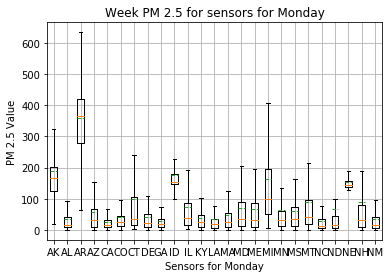

Tuesday - AK list size: 11397
Tuesday - AK list size of data above 1000: 0
Tuesday - AL list size: 33163
Tuesday - AL list size of data above 1000: 0
Tuesday - AR list size: 19974
Tuesday - AR list size of data above 1000: 0
Tuesday - AZ list size: 33183
Tuesday - AZ list size of data above 1000: 0
Tuesday - CA list size: 23382
Tuesday - CA list size of data above 1000: 0
Tuesday - CO list size: 10063
Tuesday - CO list size of data above 1000: 0
Tuesday - CT list size: 11942
Tuesday - CT list size of data above 1000: 0
Tuesday - DE list size: 37295
Tuesday - DE list size of data above 1000: 0
Tuesday - GA list size: 16893
Tuesday - GA list size of data above 1000: 0
Tuesday - ID list size: 26416
Tuesday - ID list size of data above 1000: 0
Tuesday - IL list size: 13631
Tuesday - IL list size of data above 1000: 0
Tuesday - KY list size: 8317
Tuesday - KY list size of data above 1000: 0
Tuesday - LA list size: 13012
Tuesday - LA list size of data above 1000: 0
Tuesday - MA list size: 31

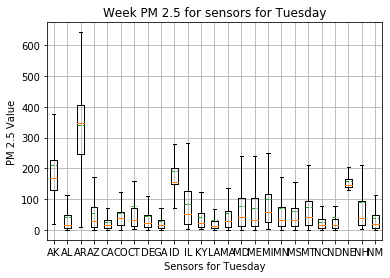

Wednesday - AK list size: 15468
Wednesday - AK list size of data above 1000: 0
Wednesday - AL list size: 32696
Wednesday - AL list size of data above 1000: 0
Wednesday - AR list size: 22313
Wednesday - AR list size of data above 1000: 0
Wednesday - AZ list size: 33826
Wednesday - AZ list size of data above 1000: 0
Wednesday - CA list size: 24342
Wednesday - CA list size of data above 1000: 0
Wednesday - CO list size: 10070
Wednesday - CO list size of data above 1000: 0
Wednesday - CT list size: 10282
Wednesday - CT list size of data above 1000: 0
Wednesday - DE list size: 37700
Wednesday - DE list size of data above 1000: 0
Wednesday - GA list size: 16963
Wednesday - GA list size of data above 1000: 0
Wednesday - ID list size: 29156
Wednesday - ID list size of data above 1000: 0
Wednesday - IL list size: 13576
Wednesday - IL list size of data above 1000: 0
Wednesday - KY list size: 8423
Wednesday - KY list size of data above 1000: 0
Wednesday - LA list size: 11427
Wednesday - LA list s

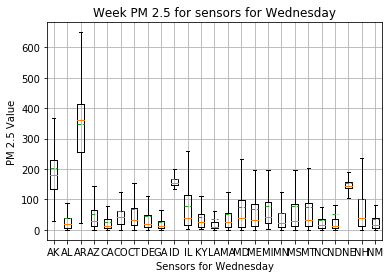

Thursday - AK list size: 15382
Thursday - AK list size of data above 1000: 0
Thursday - AL list size: 34378
Thursday - AL list size of data above 1000: 0
Thursday - AR list size: 25235
Thursday - AR list size of data above 1000: 0
Thursday - AZ list size: 34589
Thursday - AZ list size of data above 1000: 0
Thursday - CA list size: 24255
Thursday - CA list size of data above 1000: 0
Thursday - CO list size: 11298
Thursday - CO list size of data above 1000: 0
Thursday - CT list size: 8497
Thursday - CT list size of data above 1000: 0
Thursday - DE list size: 38252
Thursday - DE list size of data above 1000: 0
Thursday - GA list size: 14557
Thursday - GA list size of data above 1000: 0
Thursday - ID list size: 27680
Thursday - ID list size of data above 1000: 0
Thursday - IL list size: 14823
Thursday - IL list size of data above 1000: 0
Thursday - KY list size: 9123
Thursday - KY list size of data above 1000: 0
Thursday - LA list size: 12873
Thursday - LA list size of data above 1000: 0
T

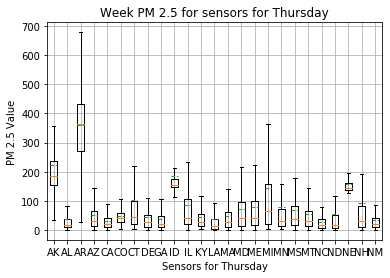

Friday - AK list size: 15972
Friday - AK list size of data above 1000: 0
Friday - AL list size: 35893
Friday - AL list size of data above 1000: 0
Friday - AR list size: 24974
Friday - AR list size of data above 1000: 0
Friday - AZ list size: 36427
Friday - AZ list size of data above 1000: 0
Friday - CA list size: 24029
Friday - CA list size of data above 1000: 0
Friday - CO list size: 13353
Friday - CO list size of data above 1000: 0
Friday - CT list size: 10512
Friday - CT list size of data above 1000: 0
Friday - DE list size: 38444
Friday - DE list size of data above 1000: 0
Friday - GA list size: 16718
Friday - GA list size of data above 1000: 0
Friday - ID list size: 28276
Friday - ID list size of data above 1000: 0
Friday - IL list size: 13967
Friday - IL list size of data above 1000: 0
Friday - KY list size: 9681
Friday - KY list size of data above 1000: 0
Friday - LA list size: 15080
Friday - LA list size of data above 1000: 0
Friday - MA list size: 31402
Friday - MA list size o

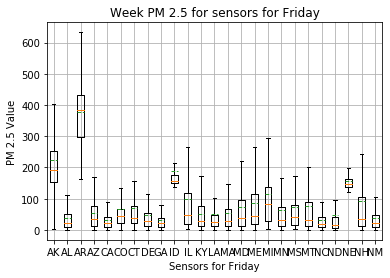

Saturday - AK list size: 16410
Saturday - AK list size of data above 1000: 0
Saturday - AL list size: 34285
Saturday - AL list size of data above 1000: 0
Saturday - AR list size: 22276
Saturday - AR list size of data above 1000: 0
Saturday - AZ list size: 36930
Saturday - AZ list size of data above 1000: 0
Saturday - CA list size: 23739
Saturday - CA list size of data above 1000: 0
Saturday - CO list size: 13017
Saturday - CO list size of data above 1000: 0
Saturday - CT list size: 9040
Saturday - CT list size of data above 1000: 0
Saturday - DE list size: 38393
Saturday - DE list size of data above 1000: 0
Saturday - GA list size: 18367
Saturday - GA list size of data above 1000: 0
Saturday - ID list size: 27498
Saturday - ID list size of data above 1000: 0
Saturday - IL list size: 16256
Saturday - IL list size of data above 1000: 0
Saturday - KY list size: 9901
Saturday - KY list size of data above 1000: 0
Saturday - LA list size: 13618
Saturday - LA list size of data above 1000: 0
S

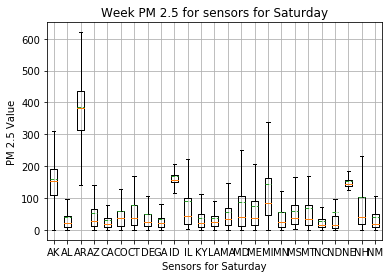

Sunday - AK list size: 14008
Sunday - AK list size of data above 1000: 0
Sunday - AL list size: 32572
Sunday - AL list size of data above 1000: 0
Sunday - AR list size: 21187
Sunday - AR list size of data above 1000: 0
Sunday - AZ list size: 35565
Sunday - AZ list size of data above 1000: 0
Sunday - CA list size: 24127
Sunday - CA list size of data above 1000: 0
Sunday - CO list size: 12557
Sunday - CO list size of data above 1000: 0
Sunday - CT list size: 9983
Sunday - CT list size of data above 1000: 0
Sunday - DE list size: 37740
Sunday - DE list size of data above 1000: 0
Sunday - GA list size: 19131
Sunday - GA list size of data above 1000: 0
Sunday - ID list size: 26056
Sunday - ID list size of data above 1000: 0
Sunday - IL list size: 14280
Sunday - IL list size of data above 1000: 0
Sunday - KY list size: 7262
Sunday - KY list size of data above 1000: 0
Sunday - LA list size: 12259
Sunday - LA list size of data above 1000: 0
Sunday - MA list size: 30996
Sunday - MA list size of

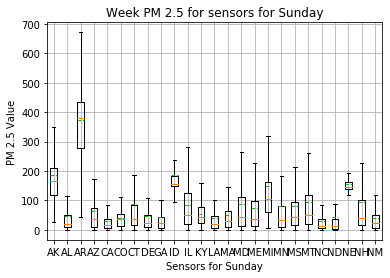

Total: 3999252


In [36]:
# modified_gers each sensors - This is the working boxplot for modified_gers only Mongolia deployed sensors

plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

all_sensors_names = []
for name, sensor_data in modified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = modified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

total = 0
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = modified_gers_data[modified_gers_data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        cumulative += len(temp.groupby("name").get_group(name)["pm2_5"].dropna())
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].dropna())
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
        print('{} - {} list size of data above 1000: {}'.format(day, name,  len(sensor_data[sensor_data.pm2_5 > 1000])))
    print ('{} total: {}'.format(day, cumulative))
    total += cumulative
    print()
    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()
print('Total: {}'.format(total))

    